# Forest: tree crown delineation

## Context
### Purpose
Accurately delineating trees using a state of the art deep learning model.

### Modelling approach
An established deep learning model, **Mask R-CNN** is deployed to delineate tree crowns accurately. A pre-trained model is provided to predict the location and extent of tree crowns from a top-down RGB image, captured by drone, aircraft or satellite.

### Highlights
* Detectree advances the state-of-the-art in tree identification from RGB images by delineating exactly the extent of the tree crown.
* Our pre-trained model was developed using aircraft images of tropical forests in Malaysia.
* The model can be further trained using the user's own images.

### Authors
Sebastian Hickman, University of Cambridge, @shmh40
James Ball, University of Cambridge, @PatBall1
Toby Jackson, University of Cambridge


*The authors acknowledge the authors of the [Detectron2](https://github.com/facebookresearch/detectron2) package which provides the Mask R-CNN architecture.*


## Install and load libraries

In [1]:
## install detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

## install geospatial libraries
!pip -q install geopandas
!pip -q install rasterio
!pip -q install fiona
!pip -q install shapely

## install intake plugins
!pip -q install git+https://github.com/ESM-VFC/intake_zenodo_fetcher.git

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/inclu

In [2]:
import cv2
from PIL import Image
import os
import numpy as np
import urllib.request
import glob

# intake library and plugin
import intake
from intake_zenodo_fetcher import download_zenodo_files_for_entry

# geospatial libraries
import geopandas as gpd

from rasterio.transform import from_origin
import rasterio.features

import fiona

from shapely.geometry import shape, mapping, box
from shapely.geometry.multipolygon import MultiPolygon

# machine learning libraries
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.config import get_cfg

# visualisation
import holoviews as hv
from IPython.display import display
import geoviews.tile_sources as gts

import hvplot.pandas
import hvplot.xarray

hv.extension('bokeh', width=100)

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/inclu

## Set folder structure

In [ ]:
# Define the project main folder
data_folder = './detectree'

# Set the folder structure
config = {
    'in_geotiff': os.path.join(data_folder, 'input','tiff'),
    'in_png': os.path.join(data_folder, 'input','png'),
    'model': os.path.join(data_folder, 'model'),
    'out_geotiff': os.path.join(data_folder, 'output','raster'),
    'out_shapefile': os.path.join(data_folder, 'output','vector'),
}

# List comprehension for the folder structure code
[os.makedirs(val) for key, val in config.items() if not os.path.exists(val)]

## Load data

#### Load in a tiff of aerial forest imagery using *intake*

In [7]:
# write a catalog YAML file
catalog_file = os.path.join(data_folder, 'catalog.yaml')

with open(catalog_file, 'w') as f:
    f.write('''
sources:
  sepilok_rgb:
    driver: rasterio
    description: 'NERC RGB images of Sepilok, Sabah, Malaysia (collection)'
    metadata:
      zenodo_doi: "10.5281/zenodo.5494629"
    args:
      urlpath: "{{ CATALOG_DIR }}/input/tiff/Sep_2014_RGB_602500_646600.tif"
      ''')

In [8]:
cat_tc = intake.open_catalog(catalog_file)

In [9]:
for catalog_entry in list(cat_tc):
    download_zenodo_files_for_entry(
        cat_tc[catalog_entry],
        force_download=False
    )

will download https://zenodo.org/api/files/271e78b4-b605-4731-a127-bd097e639bf8/Sep_2014_RGB_602500_646600.tif to /tmp/tmpwi0r7oj7/Sep_2014_RGB_602500_646600.tif


  0%|          | 0.00/100 [00:00<?, ?B/s]

In [10]:
tc_rgb = cat_tc["sepilok_rgb"].to_dask()

#### Inspect the aerial raster of the location
##### Let's investigate the data-array, what is the shape? Bounds? Bands? CRS?


In [11]:
print('shape =', tc_rgb.shape,',', 'and number of bands =', tc_rgb.count, ', crs =', tc_rgb.crs)

shape = (4, 1400, 1400) , and number of bands = <bound method ImplementsArrayReduce._reduce_method.<locals>.wrapped_func of <xarray.DataArray (band: 4, y: 1400, x: 1400)>
array([[[36166.285 , 34107.22  , ..., 20260.998 , 11166.631 ],
        [32514.84  , 28165.994 , ..., 24376.36  , 21131.947 ],
        ...,
        [15429.493 , 16034.794 , ..., 19893.691 , 19647.646 ],
        [12534.722 , 14003.215 , ..., 21438.908 , 22092.525 ]],

       [[38177.168 , 36530.74  , ..., 19060.268 , 11169.006 ],
        [34625.227 , 30270.379 , ..., 21760.09  , 20796.621 ],
        ...,
        [17757.678 , 16818.102 , ..., 22538.023 , 23093.508 ],
        [13403.302 , 13354.489 , ..., 24638.21  , 25545.938 ]],

       [[13849.501 , 14158.603 , ...,  9385.764 ,  7401.662 ],
        [13252.31  , 13373.801 , ..., 12217.845 , 10666.252 ],
        ...,
        [13471.741 , 11533.697 , ...,  7536.6924,  8397.009 ],
        [13724.59  , 11057.722 , ...,  9778.8125, 11174.72  ]],

       [[65535.    , 65535. 

#### Save the RGB bands our our tiff as a png 
##### Mask R-CNN requires images in png format. Let's export the RGB bands to a png file.

In [ ]:
minx = 602500
miny = 646600

R = tc_rgb[0]
G = tc_rgb[1]
B = tc_rgb[2]
    
# stack up the bands in an order appropriate for saving with cv2, then rescale to the correct 0-255 range for cv2

# you will have to change the rescaling depending on the values of your tiff!
rgb = np.dstack((R,G,B)) # BGR for cv2
rgb_rescaled = 255*rgb/65535 # scale to image
    
# save this as png, named with the origin of the specific tile - change the filepath!
filepath = config['in_png'] + '/' + 'tile_' + str(minx) + '_' + str(miny) + '.png'
cv2.imwrite(filepath, rgb_rescaled)

#### Now read in and display this png

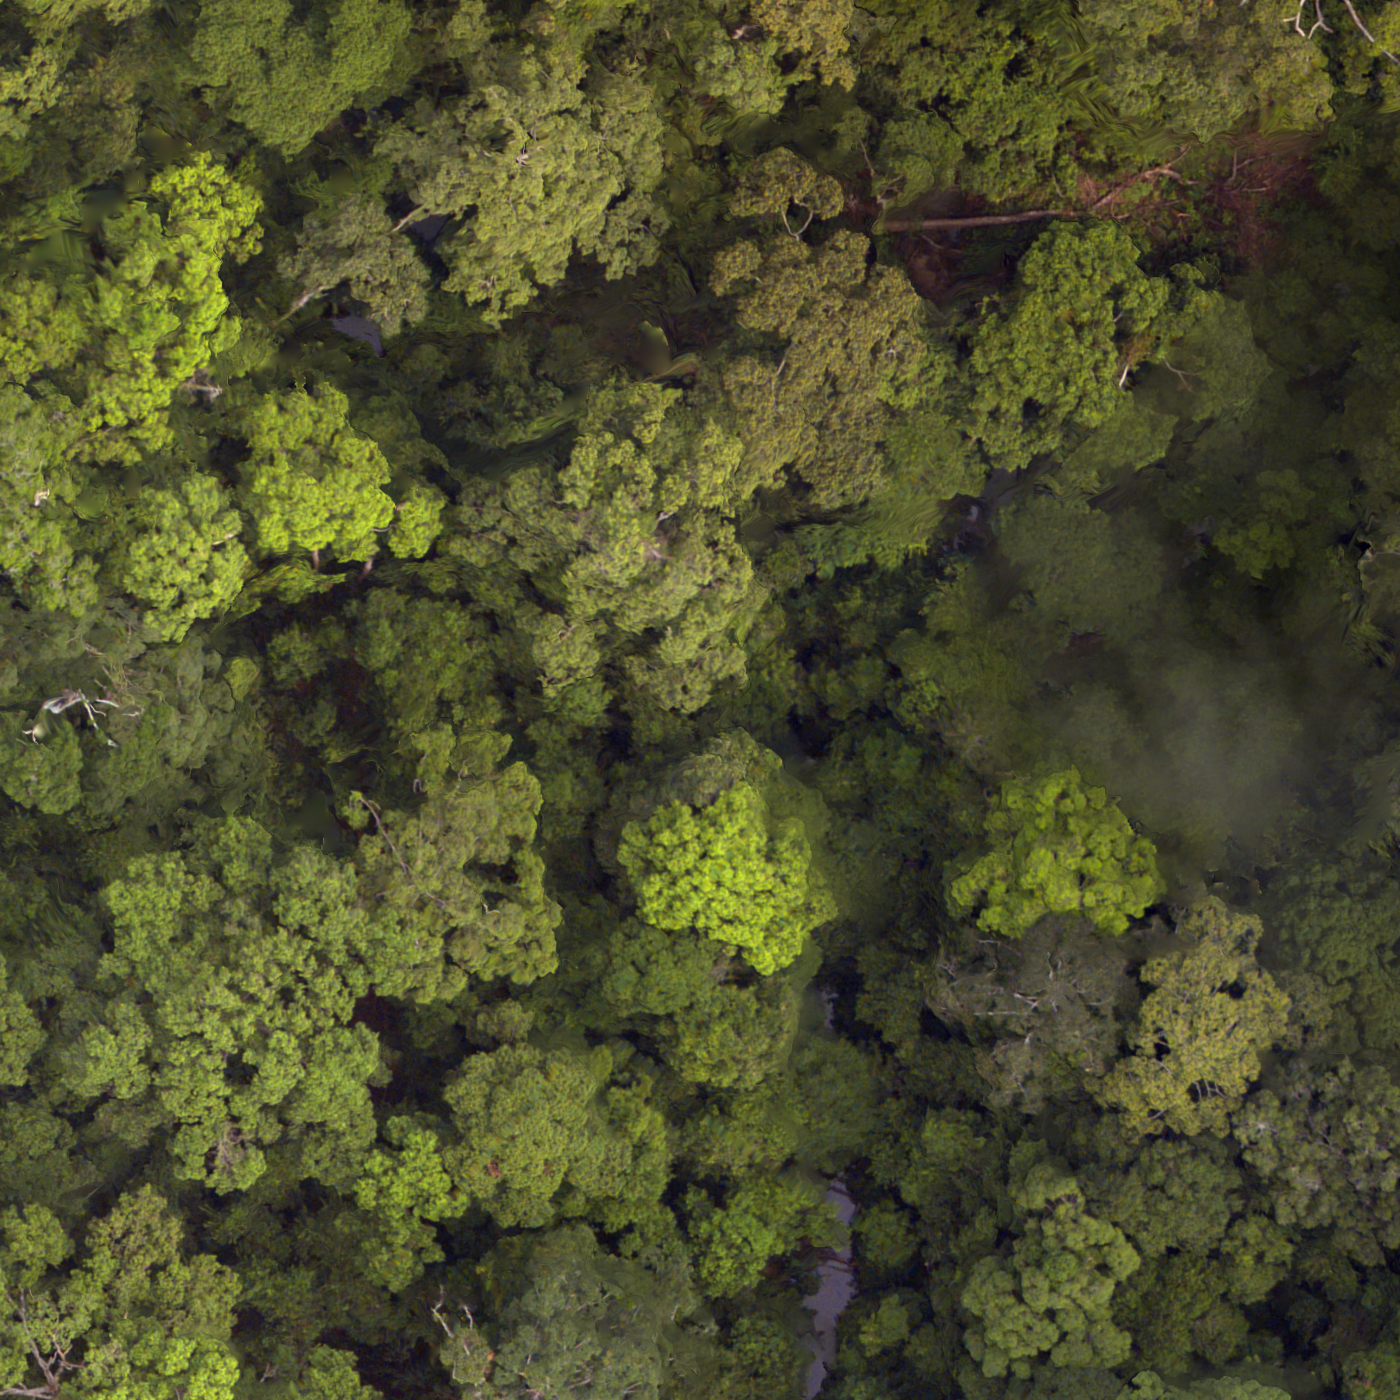

In [12]:
im = cv2.imread(filepath)
display(Image.fromarray(im))

## Download the pretrained model

In [ ]:
# define the URL to retrieve the model
fn = 'model_final.pth'
url = f'https://zenodo.org/record/5515408/files/{fn}?download=1'

urllib.request.urlretrieve(url, config['model'] + '/' + fn)

## Modelling

#### Make predictions on our png

In [13]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()

# if you want to make predictions using a CPU, run the following line. If using GPU, hash it out.
cfg.MODEL.DEVICE='cpu'

# model and hyperparameter selection
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

### path to the saved pre-trained model weights
cfg.MODEL.WEIGHTS = config['model'] + '/model_final.pth'

# set confidence threshold at which we predict
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15

predictor = DefaultPredictor(cfg)

## Outputs
#### Showing the predictions from detectree

/opt/conda/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


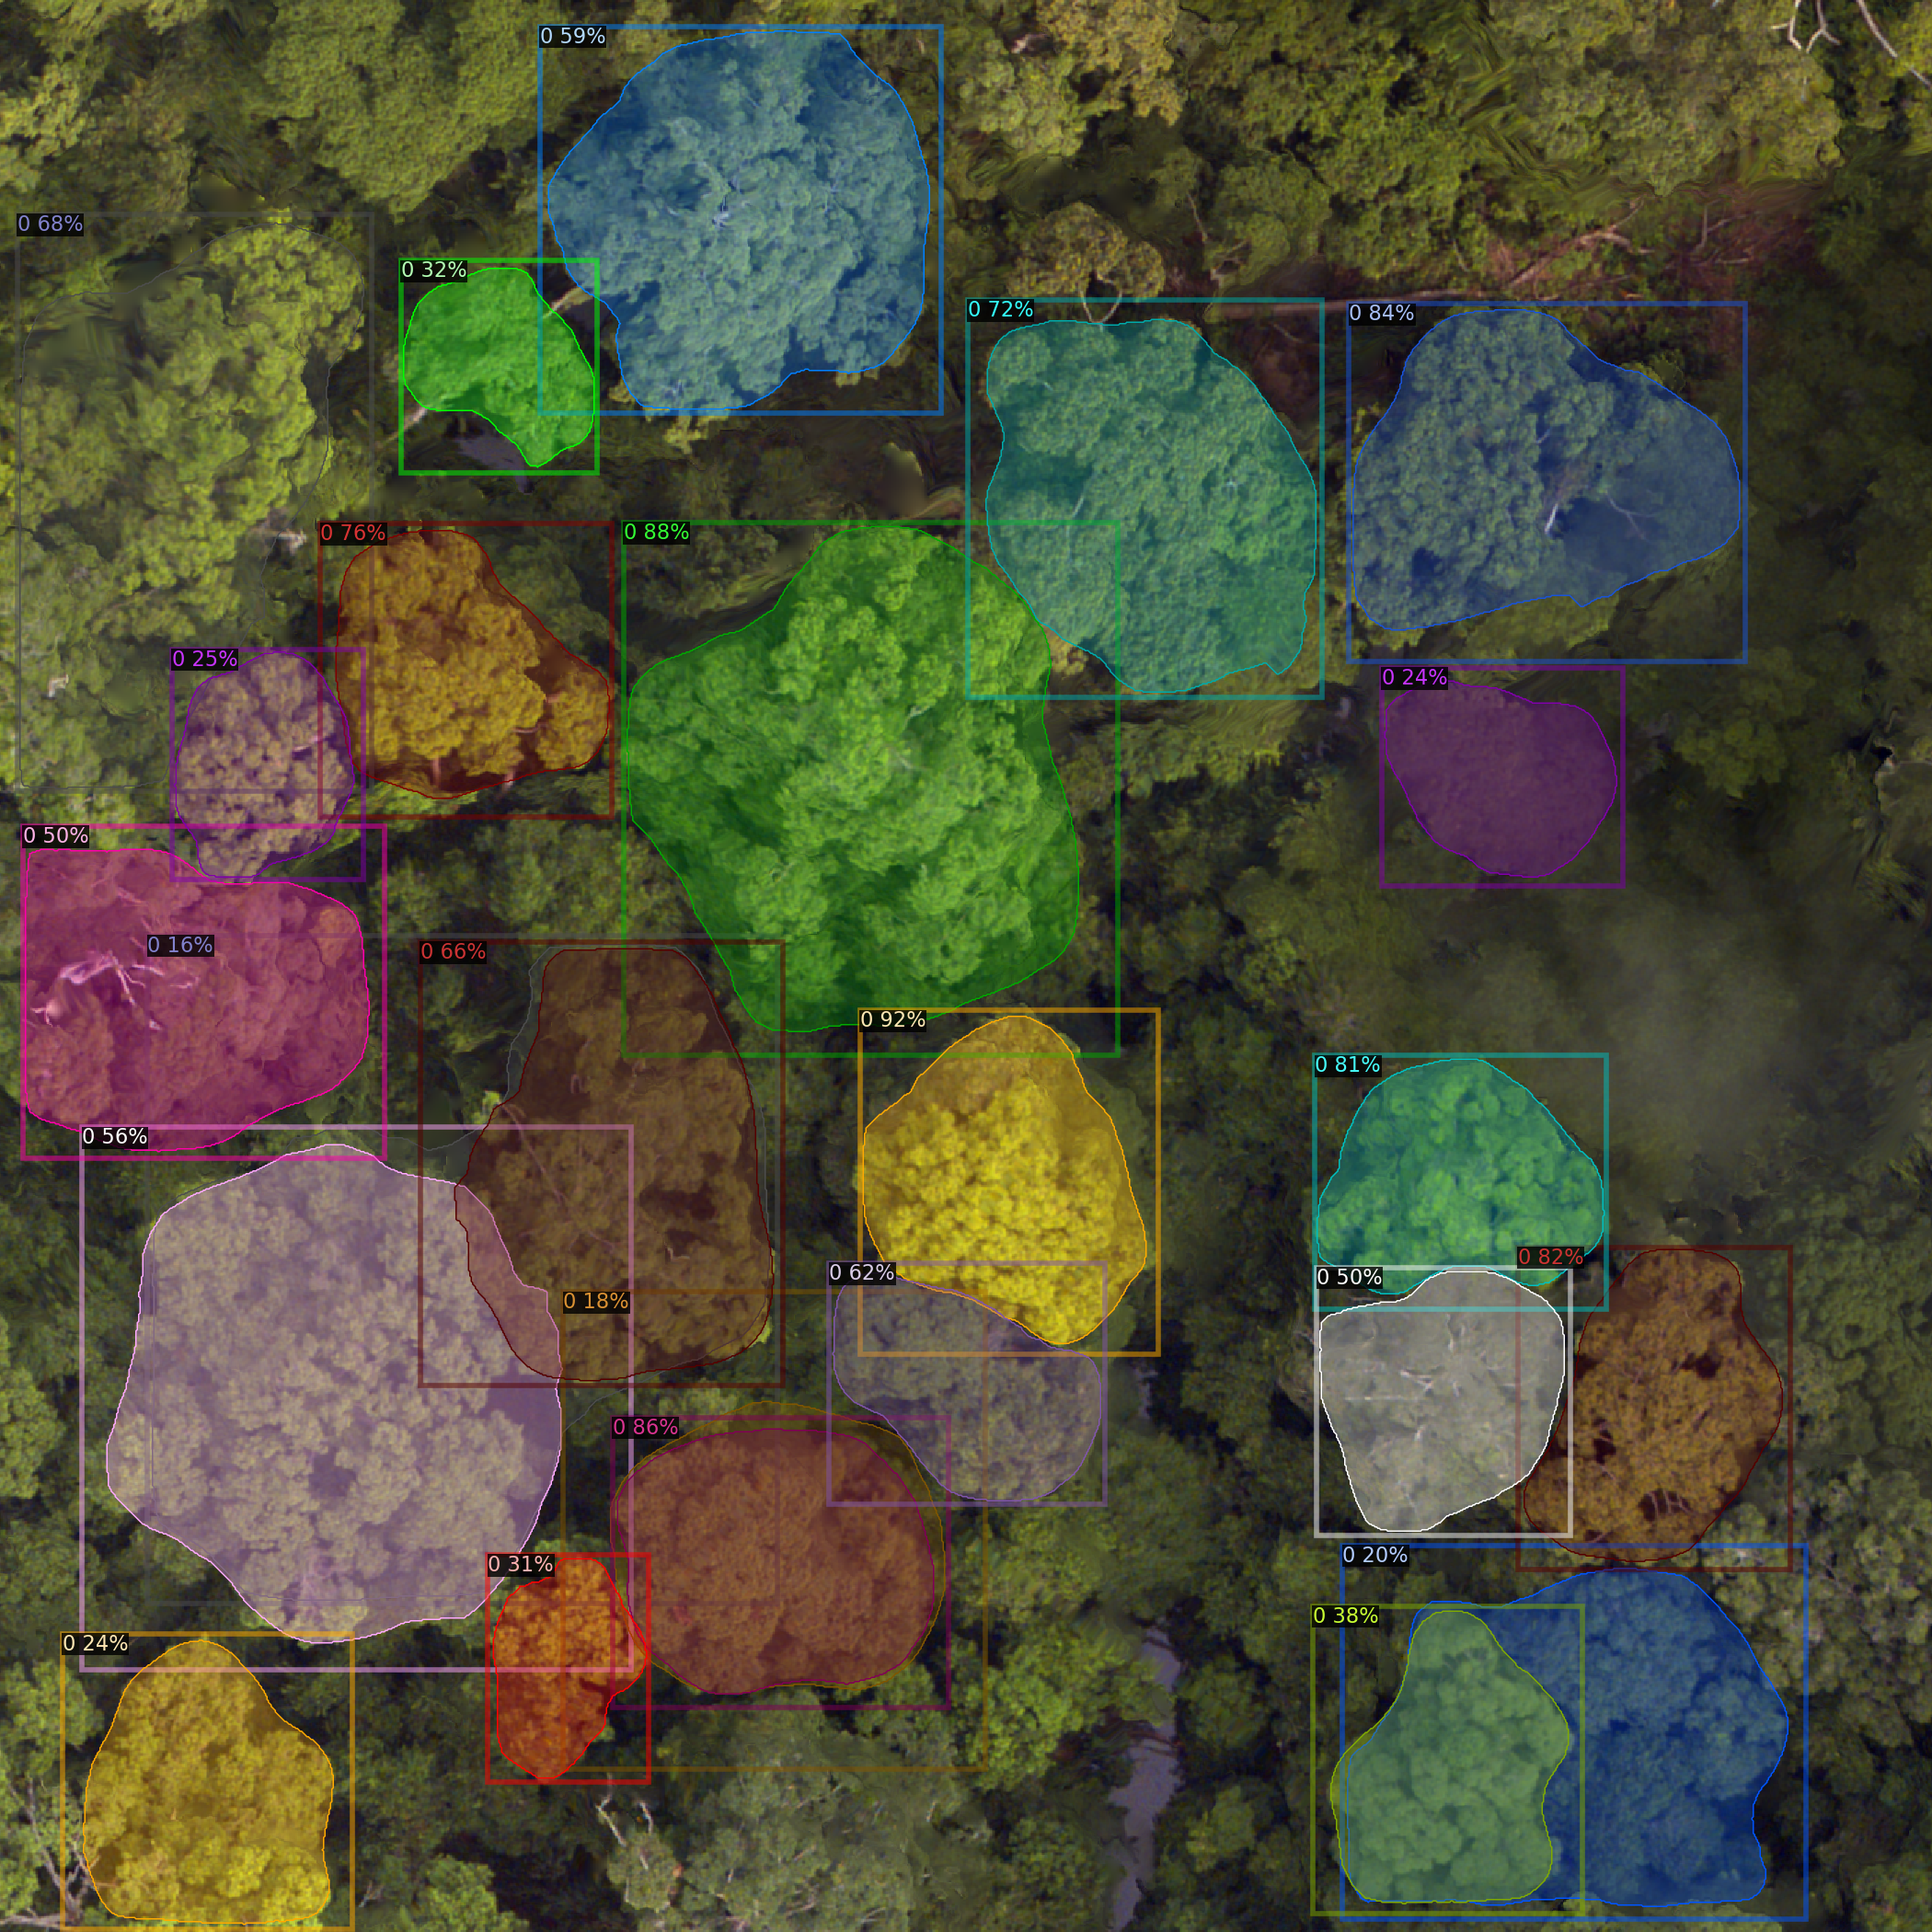

In [14]:
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], scale=1.5, instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
image = cv2.cvtColor(v.get_image()[:, :, :], cv2.COLOR_BGR2RGB)
display(Image.fromarray(image))

## Convert predictions into geospatial files
#### To GeoTiff

In [ ]:
mask_array = outputs['instances'].pred_masks.cpu().numpy()

# get confidence scores too 
mask_array_scores = outputs['instances'].scores.cpu().numpy()

num_instances = mask_array.shape[0]
mask_array_instance = []
output = np.zeros_like(mask_array) 

mask_array_instance.append(mask_array)
output = np.where(mask_array_instance[0] == True, 255, output)
fresh_output = output.astype(np.float)
x_scaling = 140/fresh_output.shape[1]
y_scaling = 140/fresh_output.shape[2]
# this is an affine transform. This needs to be altered significantly.
transform = from_origin(int(filepath[-17:-11])-20, int(filepath[-10:-4])+120, y_scaling, x_scaling)


output_raster = config['out_geotiff'] + '/' + 'predicted_rasters_' + filepath[-17:-4]+'.tif'

new_dataset = rasterio.open(output_raster, 'w', driver='GTiff',
                                height = fresh_output.shape[1], width = fresh_output.shape[2], count = fresh_output.shape[0],
                                dtype=str(fresh_output.dtype),
                                crs='+proj=utm +zone=50 +datum=WGS84 +units=m +no_defs',  
                                transform=transform)

new_dataset.write(fresh_output)
new_dataset.close()

## To Shapefile



In [ ]:
# Read input band with Rasterio
    
with rasterio.open('/home/jovyan/lustre_scratch/sepilok_data/spare_rasters/predicted_rasters_'+filepath[-17:-4]+'.tif') as src:
    shp_schema = {'geometry': 'MultiPolygon','properties': {'pixelvalue': 'int', 'score': 'float'}}    

    crs = src.crs
    for i in range(src.count):
        src_band = src.read(i+1)
        src_band = np.float32(src_band)
        conf = mask_array_scores[i]
        # Keep track of unique pixel values in the input band
        unique_values = np.unique(src_band)
        # Polygonize with Rasterio. `shapes()` returns an iterable
        # of (geom, value) as tuples
        shapes = list(rasterio.features.shapes(src_band, transform=src.transform))
    



        if i == 0:
            with fiona.open(config['out_shapefile'] + '/predicted_polygons_' + filepath[-17:-4] + '_' + str(0) + '.shp', 'w', 'ESRI Shapefile',                              shp_schema, crs) as shp:
                polygons = [shape(geom) for geom, value in shapes if value == 255.0]                                        
                multipolygon = MultiPolygon(polygons)
                        # simplify not needed here
                        #multipolygon = multipolygon_a.simplify(0.1, preserve_topology=False)                    
                shp.write({
                          'geometry': mapping(multipolygon),
                          'properties': {'pixelvalue': int(unique_values[1]), 'score': float(conf)} 
                           })
        else:
            with fiona.open(config['out_shapefile'] + '/predicted_polygons_' + filepath[-17:-4] + '_' + str(0)+'.shp', 'a', 'ESRI Shapefile',                                shp_schema, crs) as shp:
                polygons = [shape(geom) for geom, value in shapes if value == 255.0]                                        
                multipolygon = MultiPolygon(polygons)
                        # simplify not needed here
                        #multipolygon = multipolygon_a.simplify(0.1, preserve_topology=False)                    
                shp.write({
                          'geometry': mapping(multipolygon),
                          'properties': {'pixelvalue': int(unique_values[1]), 'score': float(conf)} 
                           })
    

## Interactive map to visualise the exported files

In [ ]:
### use hvplot, not leafmap - needs testing

# load and plot polygons
in_shp = glob.glob(config['out_shapefile'] + '/*.shp')

poly_df = gpd.read_file(in_shp[0])

plot_vector = poly_df.hvplot().opts(fill_color=None,line_color='red',alpha=0.8, width=800, height=600)

In [ ]:
# load and plot RGB image
r = tc_rgb.sel(band=[1,2,3])

normalized = r/(r.quantile(.99,skipna=True)/255)

mask = normalized.where(normalized < 255)

int_arr = mask.astype(int)

plot_rgb = int_arr.astype('uint8').hvplot.rgb(
    x='x', y='y', bands='band', data_aspect=1
)

In [ ]:
plot_rgb * plot_vector

## Summary

#### We have read in a raster, chosen a tile and made predictions on it. These predictions can then be transformed to shapefiles and examined in GIS software!

* We made the predictions on the png using and trained Mask R-CNN model 
* Transfer learning was used to train a pre-trained model to be able to detect trees from aerial imagery
* We then extracted our predictions, added the geospatial location back in, and exported them as shapefiles including the confidence score assigned to each prediction by the model.
* Visualised the predictions on an interactive map!